# Dataset division and pipeline saving

After the cleaning and exploratory analysis, the relevant variables were identified to construct the models. To train and test the models, we split the dataset in 80/20 proportion. Then we conformed the pipeline process in the train dataset, to be fitted into the test dataset. The pipeline has the next steps:

* Cleaning
* Feature selection
* Feature creation
* Imputter
* One hot encoding (Categorical)
* Normalization

The pipeline is saved using the pipeline function from Scikit Learn (https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). Then, this pipeline can be easily applied using the Lambda function from Amazon.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Imputer, MaxAbsScaler, OneHotEncoder, StandardScaler
from sklearn.externals import joblib

## Splitting dataset

In [2]:
df_all = pd.read_csv('./saberpro_2016-2019_cleaned_v3.zip',sep=';')
print(df_all.shape)

/home/wilomaku/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (10,11,12,14,25,26,39,42,43,44,93,94,99,107) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(963255, 110)


In [3]:
df_2019 = df_all[df_all['YEAR']==2019]
df_N2019 = df_all[df_all['YEAR']!=2019]

df_devel, df_test = train_test_split(df_2019, test_size=0.2, random_state=666)
df_devel = pd.concat([df_devel,df_N2019])

print(df_test['YEAR'].unique())
print(df_devel['YEAR'].unique(), df_devel['YEAR'].unique())
print('-------------------------------------------')
print(df_devel.shape, df_test.shape)

[2019]
[2019 2016 2017 2018] [2019 2016 2017 2018]
-------------------------------------------
(911242, 110) (52013, 110)


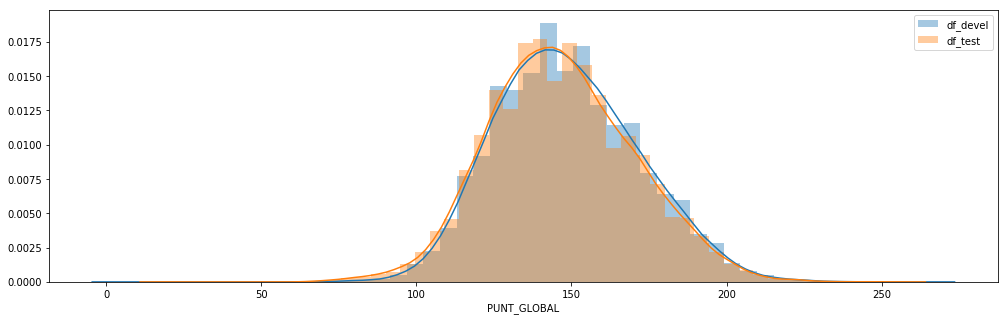

In [4]:
fig, axes = plt.subplots(figsize=(17, 5))

sns.distplot(df_devel['PUNT_GLOBAL'], label='df_devel')
sns.distplot(df_test['PUNT_GLOBAL'], label='df_test')

plt.legend()
plt.show()

In [5]:
df_devel.to_csv('./saberpro_2016-2019_devel_v3.csv',sep=';',index=False)
df_test.to_csv('./saberpro_2016-2019_test_v3.csv',sep=';',index=False)

## Joining with homicides dataset

In [6]:
df_vio_mun = pd.read_csv('Homicidios_municipio.zip')
print(df_vio_mun.shape)
df_vio_mun.head()

(8198, 7)


,YEAR,MUNICIPIO,CODIGO DANE,HOMICIDIOS,DEPARTAMENTO,POBLACION TOTAL,TASA_HOMICIDIOS
0,2010,ABEJORRAL,5002,4.0,Antioquia,21355.0,18.730976
1,2010,ABREGO,54003,8.0,Norte de Santander,33554.0,23.842165
2,2010,ACACÍAS,50006,30.0,Meta,65522.0,45.786148
3,2010,ACANDÍ,27006,2.0,Chocó,12547.0,15.940065
4,2010,ACEVEDO,41006,12.0,Huila,28142.0,42.640893


In [7]:
def func_tasa_hom(vars_vio,y_prev=4):

    cod_mun, year = vars_vio[0], vars_vio[1]
    years_vio = np.arange(year-y_prev-1,year+1).astype(int)
    TASA_HOMICIDIOS_AVG = df_vio_mun.loc[(df_vio_mun['YEAR'].isin(years_vio))&
                                         (df_vio_mun['CODIGO DANE']==cod_mun),
                                         'TASA_HOMICIDIOS'].mean()
    return TASA_HOMICIDIOS_AVG

df_devel['TASA_HOMICIDIOS_4'] = df_devel[['ESTU_COD_RESIDE_MCPIO','YEAR']].apply(func_tasa_hom,axis=1)
df_test['TASA_HOMICIDIOS_4'] = df_test[['ESTU_COD_RESIDE_MCPIO','YEAR']].apply(func_tasa_hom,axis=1)

/home/wilomaku/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [8]:
def func_tasa_hom(vars_vio,y_prev=1):

    cod_mun, year = vars_vio[0], vars_vio[1]
    years_vio = np.arange(year-y_prev-1,year+1).astype(int)
    TASA_HOMICIDIOS_AVG = df_vio_mun.loc[(df_vio_mun['YEAR'].isin(years_vio))&
                                         (df_vio_mun['CODIGO DANE']==cod_mun),
                                         'TASA_HOMICIDIOS'].mean()
    return TASA_HOMICIDIOS_AVG

df_devel['TASA_HOMICIDIOS_1'] = df_devel[['ESTU_COD_RESIDE_MCPIO','YEAR']].apply(func_tasa_hom,axis=1)
df_test['TASA_HOMICIDIOS_1'] = df_test[['ESTU_COD_RESIDE_MCPIO','YEAR']].apply(func_tasa_hom,axis=1)

/home/wilomaku/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [9]:
df_devel.to_csv('./saberpro_2016-2019_devel_v4.csv',sep=';',index=False)
df_test.to_csv('./saberpro_2016-2019_test_v4.csv',sep=';',index=False)

## Constructing and saving preprocess pipeline

In [2]:
class ColumnExtractor(BaseEstimator, TransformerMixin):

    def __init__(self, columns=None):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X_cols = X[self.columns]
        return X_cols

def create_feat(df):

    #Nacionalidad
    filter_nac = (df['ESTU_NACIONALIDAD']!='COLOMBIA')&(df['ESTU_NACIONALIDAD'].notnull())
    df.loc[filter_nac,'ESTU_NACIONALIDAD'] = 0

    filter_nac = df['ESTU_NACIONALIDAD']=='COLOMBIA'
    df.loc[filter_nac,'ESTU_NACIONALIDAD'] = 1

    #df['ESTU_NACIONALIDAD'] = df['ESTU_NACIONALIDAD'].astype('bool')

    #Método programa
    filter_nac = (df['ESTU_METODO_PRGM'] == 'DISTANCIA') | (df['ESTU_METODO_PRGM'] == 'SEMI-PRESENCIAL')
    df.loc[filter_nac,'ESTU_METODO_PRGM'] = 'DISTANCIA/SEMI-PRESENCIAL'

    filter_nac = df['ESTU_METODO_PRGM'] == 'DISTANCIA VITUAL'
    df.loc[filter_nac,'ESTU_METODO_PRGM'] = 'DISTANCIA VIRTUAL'

    #Carácter académico
    filter_nac = (df['INST_CARACTER_ACADEMICO']=='INSTITUCIÓN TECNOLÓGICA') |\
                 (df['INST_CARACTER_ACADEMICO']=='INSTITUCIÓN UNIVERSITARIA')
    df.loc[filter_nac,'INST_CARACTER_ACADEMICO'] = 'TECNOLÓGICA/UNIVERSITARIA'
    
    #Institución educativa
    l_inst = ['CORPORACION UNIVERSITARIA MINUTO DE DIOS','POLITECNICO GRANCOLOMBIANO',
              'UNIVERSIDAD COOPERATIVA DE COLOMBIA','UNIVERSIDAD NACIONAL ABIERTA Y A DISTANCIA UNAD',
              'UNIVERSIDAD NACIONAL DE COLOMBIA','FUNDACION UNIVERSITARIA DEL AREA ANDINA','UNIVERSIDAD LIBRE',
              'UNIVERSIDAD DE ANTIOQUIA','UNIVERSIDAD SANTO TOMAS','PONTIFICIA UNIVERSIDAD JAVERIANA',
              'CORPORACION UNIFICADA NACIONAL DE EDUCACION SUPERIOR','UNIVERSIDAD DEL TOLIMA',
              'CORPORACION UNIVERSITARIA REMINGTON','UNIVERSIDAD PONTIFICIA BOLIVARIANA',
              'UNIVERSIDAD PEDAGOGICA Y TECNOLOGICA DE COLOMBIA','UNIVERSIDAD DEL ATLANTICO',
              'UNIVERSIDAD DE PAMPLONA','UNIVERSIDAD DEL QUINDIO','UNIVERSIDAD FRANCISCO DE PAULA SANTANDER',
              'UNIVERSIDAD DE LOS ANDES','UNIVERSIDAD DEL VALLE','UNIVERSIDAD ANTONIO NARIÑO',
              'UNIVERSIDAD DE CARTAGENA','UNIVERSIDAD DE SAN BUENAVENTURA',
              'CORPORACION UNIVERSITARIA IBEROAMERICANA','UNIVERSIDAD SIMON BOLIVAR',
              'UNIVERSIDAD INDUSTRIAL DE SANTANDER','UNIVERSIDAD DE LA SALLE','UNIVERSIDAD LA GRAN COLOMBIA',
              'UNIVERSIDAD DEL MAGDALENA','UNIVERSIDAD SANTIAGO DE CALI',
              'UNIVERSIDAD DISTRITALFRANCISCO JOSE DE CALDAS','CORPORACION UNIVERSITARIA DEL CARIBE',
              'UNIVERSIDAD ECCI','UNIVERSIDAD MILITARNUEVA GRANADA','FUNDACION UNIVERSITARIA LUIS AMIGO FUNLAM',
              'UNIVERSIDAD DE CORDOBA','FUNDACION UNIVERSITARIA LOS LIBERTADORES','UNIVERSIDAD DEL NORTE',
              'UNIVERSIDAD DE CUNDINAMARCA','UNIVERSIDAD TECNOLOGICA DE PEREIRA','UNIVERSIDAD POPULAR DEL CESAR',
              'UNIVERSIDAD DEL CAUCA','FUNDACION UNIVERSIDAD DE BOGOTAJORGE TADEO LOZANO',
              'CORPORACION UNIVERSIDAD DE LA COSTA, CUC','ESCUELA SUPERIOR DE ADMINISTRACION PUBLICA',
              'UNIVERSIDAD EL BOSQUE','UNIVERSIDAD DE LA GUAJIRA','UNIVERSIDAD AUTONOMA DEL CARIBE',
              'UNIVERSIDAD CATOLICA DE COLOMBIA','UNIVERSIDAD EAFIT','UNIVERSIDAD DE MEDELLIN',
              'COLEGIO MAYOR DE NUESTRA SEÑORA DEL ROSARIO','FUNDACION UNIVERSITARIA SAN MARTIN',
              'UNIVERSIDAD SURCOLOMBIANA','UNIVERSIDAD DE CALDAS','UNIVERSIDAD CENTRAL','UNIVERSIDAD DE LA SABANA',
              'UNIVERSIDAD DEL SINÚ Elías Bechara Zainúm','UNIVERSIDAD SERGIO ARBOLEDA','UNIVERSIDAD DE SANTANDER',
              'UNIVERSIDAD AUTONOMA DE OCCIDENTE','CORPORACION UNIVERSITARIA AMERICANA']
    
    df['INST_NOMBRE_INSTITUCION'] = df['INST_NOMBRE_INSTITUCION'].apply(lambda x: x.replace('"',''))
    df['INST_NOMBRE_INSTITUCION'] = df['INST_NOMBRE_INSTITUCION'].apply(lambda x: x.replace("'",''))
    df['INST_NOMBRE_INSTITUCION'] = df['INST_NOMBRE_INSTITUCION'].apply(lambda x: x.split('-')[0].strip())
    df.loc[~df['INST_NOMBRE_INSTITUCION'].isin(l_inst),'INST_NOMBRE_INSTITUCION'] = 'new'

    #Lectura
    filter_nac = (df['ESTU_DEDICACIONLECTURADIARIA']=='No leo por entretenimiento')
    df.loc[filter_nac,'ESTU_DEDICACIONLECTURADIARIA'] = '30 minutos o menos'

    filter_nac = (df['ESTU_DEDICACIONLECTURADIARIA']=='Entre 1 y 2 horas') |\
                 (df['ESTU_DEDICACIONLECTURADIARIA']=='Entre 30 y 60 minutos')
    df.loc[filter_nac,'ESTU_DEDICACIONLECTURADIARIA'] = 'Entre 30 mins y 2 horas'

    df['ESTU_DEDICACIONLECTURADIARIA'] = pd.Categorical(df['ESTU_DEDICACIONLECTURADIARIA'],ordered=True,
                    categories=['30 minutos o menos','Entre 30 mins y 2 horas','Más de 2 horas'])

    #Internet
    filter_nac = (df['ESTU_DEDICACIONINTERNET']=='Entre 1 y 3 horas') |\
                 (df['ESTU_DEDICACIONINTERNET']=='Más de 4 horas')
    df.loc[filter_nac,'ESTU_DEDICACIONINTERNET'] = 'Mas de 1 hora'

    df['ESTU_DEDICACIONINTERNET'] = pd.Categorical(df['ESTU_DEDICACIONINTERNET'],ordered=True,
                    categories=['Menos de una hora','Mas de 1 hora',])

    #Semestre que cursa
    filter_nac = (df['ESTU_SEMESTRECURSA'] <= 5.0)
    df.loc[filter_nac,'ESTU_SEMESTRECURSA'] = 5.0

    filter_nac = (df['ESTU_SEMESTRECURSA'] > 5.0) & (df['ESTU_SEMESTRECURSA'] <= 10.0)
    df.loc[filter_nac,'ESTU_SEMESTRECURSA'] = 10.0

    filter_nac = (df['ESTU_SEMESTRECURSA'] > 10.0)
    df.loc[filter_nac,'ESTU_SEMESTRECURSA'] = 11.0

    filter_nac = (df['ESTU_SEMESTRECURSA'] == 5.0)
    df.loc[filter_nac,'ESTU_SEMESTRECURSA'] = 'Menos de 6 semestres'

    filter_nac = (df['ESTU_SEMESTRECURSA'] == 10.0)
    df.loc[filter_nac,'ESTU_SEMESTRECURSA'] = 'Entre 6 y 10 semestres'

    filter_nac = (df['ESTU_SEMESTRECURSA'] == 11.0)
    df.loc[filter_nac,'ESTU_SEMESTRECURSA'] = 'Mas de 10 semestres'

    df['ESTU_SEMESTRECURSA'] = pd.Categorical(df['ESTU_SEMESTRECURSA'],ordered=True,
                                              categories=['Menos de 6 semestres','Entre 6 y 10 semestres',
                                                          'Mas de 10 semestres'])

    #Valor matrícula
    filter_nac = (df['ESTU_VALORMATRICULAUNIVERSIDAD']=='No pagó matrícula')
    df.loc[filter_nac,'ESTU_VALORMATRICULAUNIVERSIDAD'] = 'Menos de 500 mil'

    filter_nac = (df['ESTU_VALORMATRICULAUNIVERSIDAD'] == 'Entre 500 mil y menos de 1 millón') |\
                 (df['ESTU_VALORMATRICULAUNIVERSIDAD'] == 'Entre 1 millón y menos de 2.5 millones') |\
                 (df['ESTU_VALORMATRICULAUNIVERSIDAD'] == "['Entre 1 millón y menos de 2.5 millones']") |\
                 (df['ESTU_VALORMATRICULAUNIVERSIDAD'] == 'Entre 2.5 millones y menos de 4 millones')
    df.loc[filter_nac,'ESTU_VALORMATRICULAUNIVERSIDAD'] = 'Entre 500 mil y menos de 4 millones'

    filter_nac = (df['ESTU_VALORMATRICULAUNIVERSIDAD'] == 'Entre 4 millones y menos de 5.5 millones') |\
                 (df['ESTU_VALORMATRICULAUNIVERSIDAD'] == 'Entre 5.5 millones y menos de 7 millones')
    df.loc[filter_nac,'ESTU_VALORMATRICULAUNIVERSIDAD'] = 'Entre 4 millones y menos de 7 millones'

    filter_nac = df['ESTU_VALORMATRICULAUNIVERSIDAD']=='Más de 7 millones'
    df.loc[filter_nac,'ESTU_VALORMATRICULAUNIVERSIDAD'] = 'Mas de 7 millones'

    df['ESTU_VALORMATRICULAUNIVERSIDAD'] = pd.Categorical(df['ESTU_VALORMATRICULAUNIVERSIDAD'],ordered=True,
                                       categories=['Menos de 500 mil','Entre 500 mil y menos de 4 millones',
                                                   'Entre 4 millones y menos de 7 millones','Mas de 7 millones'])

    #Educación padres
    for col in ['FAMI_EDUCACIONMADRE','FAMI_EDUCACIONPADRE']:
        df[col] = df[col].str.lower()
        filter_nac = (df[col]=='Primaria incompleta') | (df[col]=='Primaria completa')
        df.loc[filter_nac,col] = 'Primaria'

        filter_nac = (df[col]=='Secundaria (Bachillerato) incompleta') |\
                     (df[col]=='Secundaria (Bachillerato) completa') |\
                     (df[col]=='Técnica o tecnológica incompleta')
        df.loc[filter_nac,col] = 'Secundaria'

        filter_nac = df[col]=='Técnica o tecnológica completa'
        df.loc[filter_nac,col] = 'Técnica o tecnológica'

        filter_nac = (df[col]=='Educación profesional incompleta') |\
                     (df[col]=='Educación profesional completa')
        df.loc[filter_nac,col] = 'Educación profesional'

        filter_nac = df[col].isnull()
        df.loc[filter_nac,col] = 'No sabe/No Aplica'

        df[col] = pd.Categorical(df[col],ordered=True,
                                 categories=['No sabe/No Aplica','Ninguno','Primaria','Secundaria',
                                             'Técnica o tecnológica','Educación profesional','Postgrado',])

    dict_fam_edu = dict(zip(df['FAMI_EDUCACIONMADRE'].cat.codes, df['FAMI_EDUCACIONMADRE']))
    #dict_fam_edu_test = dict(zip(df['FAMI_EDUCACIONPADRE'].cat.codes, df['FAMI_EDUCACIONPADRE']))

    #if dict_fam_edu != dict_fam_edu_test:
    #    raise NameError('Dictionaries are different! Please take a look!')

    df['FAMI_EDUCACION_PADRES'] = pd.concat([df['FAMI_EDUCACIONPADRE'].cat.codes,
                                             df['FAMI_EDUCACIONMADRE'].cat.codes],axis=1).max(axis=1)
    df['FAMI_EDUCACION_PADRES'] = df['FAMI_EDUCACION_PADRES'].apply(lambda x: dict_fam_edu[x])

    df['FAMI_EDUCACION_PADRES'] = pd.Categorical(df['FAMI_EDUCACION_PADRES'],ordered=True,
                                                 categories=['No sabe/No Aplica','Ninguno','Primaria',
                                                             'Secundaria','Técnica o tecnológica',
                                                             'Educación profesional','Postgrado',])

    #Trabajo
    filter_nac = (df['ESTU_HORASSEMANATRABAJA'] == 'Menos de 10 horas') |\
                 (df['ESTU_HORASSEMANATRABAJA'] == 'Entre 11 y 20 horas') |\
                 (df['ESTU_HORASSEMANATRABAJA'] == 'Entre 21 y 30 horas')
    df.loc[filter_nac,'ESTU_HORASSEMANATRABAJA'] = 'Menos de 30 horas'

    df['ESTU_HORASSEMANATRABAJA'] = pd.Categorical(df['ESTU_HORASSEMANATRABAJA'],ordered=True,
                                    categories=['0','Menos de 30 horas','Más de 30 horas',])


    #Número de libros por familia
    df['FAMI_NUMLIBROS'] = pd.Categorical(df['FAMI_NUMLIBROS'],ordered=True,
                                          categories=['0 A 10 LIBROS','11 A 25 LIBROS',
                                                      '26 A 100 LIBROS','MÁS DE 100 LIBROS'])

    #Estrato de vivienda
    df['FAMI_ESTRATOVIVIENDA'] = pd.Categorical(df['FAMI_ESTRATOVIVIENDA'],ordered=True,
                                                categories=[0.0,1.0,2.0,3.0,4.0,5.0,6.0])

    #Edad
    df['AGE_APROX'] = df['YEAR'] - pd.to_datetime(df['ESTU_FECHANACIMIENTO_ASSERT'],format='%m/%d/%Y').dt.year

    #Violencia
    df['TASA_HOMICIDIOS_4_LOG'] = np.log(df['TASA_HOMICIDIOS_4'])

    return df

class create_features(TransformerMixin):

    def transform(self, df, **transform_params):

        return create_feat(df)

    def fit(self, X, y=None, **fit_params):
        return self
    
def create_featureunion(feat_in):

    imputer_mf_bf = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
    imputer_mf_cf = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')
    imputer_mf_cfn = SimpleImputer(missing_values=np.NaN, strategy='constant', fill_value='new')
    imputer_md = SimpleImputer(missing_values=np.NaN, strategy='median')
    
    onehot_cf = OneHotEncoder(handle_unknown='ignore', sparse=False)
    onehot_cfn = OneHotEncoder(handle_unknown='ignore', sparse=False)
    scaler = MaxAbsScaler()
    normal_bf = StandardScaler()
    normal_nf = StandardScaler()
    normal_cf = StandardScaler()
    normal_cfn = StandardScaler()

    feat_concat = []

    if 'bin_feat' in feat_in:
        feat_concat.insert(-1,('pass_bin', Pipeline([('pass_bin_pl',
                                                      ColumnExtractor(columns=feat_in['bin_feat'])),
                                                     ('imputer',imputer_mf_bf),
                                                     ('scaler',normal_bf),
                                                     ])))

    if 'num_feat' in feat_in:
        feat_concat.insert(-1,('pass_num', Pipeline([('pass_num_pl',
                                                      ColumnExtractor(columns=feat_in['num_feat'])),
                                                     ('imputer',imputer_md),
                                                     ('scaler',normal_nf),
                                                     ])))

    if 'cat_feat' in feat_in:
        feat_concat.insert(-1,('dummie', Pipeline([('dumm_pl',
                                                    ColumnExtractor(columns=feat_in['cat_feat'])),
                                                   ('imputer',imputer_mf_cf),
                                                   ('onehot',onehot_cf),
                                                   ('scaler',normal_cf),
                                                   ])))

    if 'cat_feat_nan' in feat_in:
        feat_concat.insert(-1,('dummie_nan', Pipeline([('dumm_pl',
                                                        ColumnExtractor(columns=feat_in['cat_feat_nan'])),
                                                       ('imputer',imputer_mf_cfn),
                                                       ('onehot',onehot_cfn),
                                                       ('scaler',normal_cfn),
                                                       ])))

    return feat_concat

def extract_name_cols(df, feat_in, feat_in_concat):
    
    name_columns = []
    for col_pipe in feat_in_concat:
        for sub_col in col_pipe[1].steps[0][1].columns:
            if sub_col in feat_in['bin_feat']:
                name_columns.append(sub_col)
            elif sub_col in feat_in['num_feat']:
                name_columns.append(sub_col)
            elif sub_col in feat_in['cat_feat']:
                cols_unique = ['{}_{}'.format(sub_col,str(col_uni)) for col_uni in list(df[sub_col].unique()) if str(col_uni) != 'nan']
                cols_unique.sort()
                name_columns.extend(cols_unique)
            elif sub_col in feat_in['cat_feat_nan']:
                cols_unique = ['{}_{}'.format(sub_col,str(col_uni)) for col_uni in list(df[sub_col].unique())]
                cols_unique.sort()
                name_columns.extend(cols_unique)
            else:
                raise NameError('Column type not understood!')

    return name_columns

def Rename_Cols(df, features):
    return pd.DataFrame(df,columns=features)

class RenameCols(TransformerMixin):
    def __init__(self, features=None):
        self.features = features

    def transform(self, df, **transform_params):
        return Rename_Cols(df, self.features)
    
    def fit(self, df, y=None, **fit_params):
        return self

def pipeline_features(X_set, Y_set, feat):

    pipe_pre = Pipeline([('create_features',create_features()),
                        ])
    
    X_transform = pipe_pre.fit_transform(X_set, Y_set)
    
    feat_concat = create_featureunion(feat)
    new_feat = extract_name_cols(X_transform,feat,feat_concat)

    pipe_base = Pipeline([('features', FeatureUnion(feat_concat)),
                          ('re_name_cols', RenameCols(new_feat)),
                         ])

    pipe_base.fit(X_transform)
    
    return Pipeline([('pipe_pre', pipe_pre), ('pipe_base', pipe_base)])

In [7]:
df_devel = pd.read_csv('./saberpro_2016-2019_test_v4.csv',sep=';')

In [11]:
df_devel['FAMI_EDUCACIONMADRE'].unique()

array(['Secundaria (Bachillerato) completa', 'Postgrado',
       'Técnica o tecnológica incompleta',
       'Secundaria (Bachillerato) incompleta', 'Primaria incompleta',
       'Técnica o tecnológica completa', 'Educación profesional completa',
       'Primaria completa', 'Ninguno', 'Educación profesional incompleta',
       nan, 'No sabe/No Aplica'], dtype=object)

In [4]:
feat_dic = {'bin_feat':['ESTU_NACIONALIDAD',],
            'cat_feat':['ESTU_EXTERIOR','ESTU_DEPTO_RESIDE','ESTU_VALORMATRICULAUNIVERSIDAD',
                        'PAGOMATRICULA','GRUPOREFERENCIA','ESTU_METODO_PRGM','INST_CARACTER_ACADEMICO',
                        'ESTU_HORASSEMANATRABAJA','FAMI_EDUCACION_PADRES'],
            'cat_feat_nan':['ESTU_GENERO','ESTU_AREARESIDE','ESTU_SEMESTRECURSA',
                            'ESTU_DEDICACIONLECTURADIARIA','ESTU_DEDICACIONINTERNET','FAMI_NUMLIBROS',
                            'INST_NOMBRE_INSTITUCION',],
            'num_feat':['ESTU_INSE_INDIVIDUAL','TASA_HOMICIDIOS_4_LOG','AGE_APROX'],
           }

feat_list = [col for key in feat_dic for col in feat_dic[key]]

pipe = pipeline_features(df_devel, df_devel['PUNT_GLOBAL'], feat_dic,)#df_clean[feat_list]

/home/wilomaku/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/wilomaku/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [5]:
pipe_file = './saves/'
joblib.dump(pipe, '{}pipe_preprocN_270720.pkl'.format(pipe_file))

['./saves/pipe_preprocN_270720.pkl']